In [5]:
import SimpleITK as sitk
import os
import matplotlib.pyplot as plt

In [6]:
def display_image(img):
    plt.imshow(sitk.GetArrayFromImage(img), cmap='gray')
    plt.axis("off")

def overlay_fixed_moving(fixed, moving):
    img1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    img2 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
    cimg = sitk.Compose(img1, img2, sitk.Cast(img1/2. + img2/2., sitk.sitkUInt8))
    plt.imshow(sitk.GetArrayFromImage(cimg))
    plt.axis("off")

# Non-rigid Registration

Non-rigid registration methods are capable of aligning images where correspondence cannot be achieved without localized deformations and can therefore better accomodate anatomical, physiological and pathological variability between patients.

B-splines are often used to parameterize a free-form deformation (FFD) field. This is a much harder registration problem than any of the previous examples due to a much higher-dimensional parameter space and we are therefore best off using a multi-resolution approach with affine initialization. This is very easy to do in SimpleElastix.

In [7]:
dataPath = os.path.join(os.sep, "Users", "tannersorensen", "SimpleElastix-fork", \
                        "SimpleElastix-build", "SimpleITK-build", "ExternalData", \
                        "Testing", "Data", "Input")

fixedFilename = "BrainProtonDensitySliceShifted13x17y.png"
fixedImage = sitk.ReadImage(os.path.join(dataPath, fixedFilename), sitk.sitkUInt8)

movingFilename = "BrainProtonDensitySliceR10X13Y17.png"
movingImage = sitk.ReadImage(os.path.join(dataPath, movingFilename), sitk.sitkUInt8)

Consider the following mean image of two different subjects.

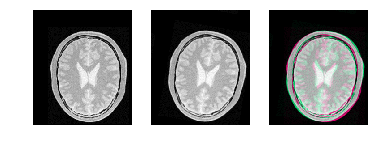

In [8]:
# fixed image
plt.subplot(1,3,1)
display_image(fixedImage)

# moving image
plt.subplot(1,3,2)
display_image(movingImage)

# fixed image (red) and moving image (green),
# with overlap in white
plt.subplot(1,3,3)
overlay_fixed_moving(fixedImage, movingImage)

The following code runs multi-resolution affine initialization and starts a non-rigid method multi-resolution non-rigid method using the affine transform as initialization :

In [12]:
elastixImageFilter = sitk.ElastixImageFilter()
elastixImageFilter.SetFixedImage(fixedImage)
elastixImageFilter.SetMovingImage(movingImage)

parameterMapVector = sitk.VectorOfParameterMap()
parameterMapVector.append(sitk.GetDefaultParameterMap("affine"))
parameterMapVector.append(sitk.GetDefaultParameterMap("bspline"))
elastixImageFilter.SetParameterMap(parameterMapVector)

elastixImageFilter.Execute()
resultImage = elastixImageFilter.GetResultImage()
sitk.WriteImage(sitk.Cast(resultImage, sitk.sitkUInt8), "nonrigid_result_"+movingFilename)

The result image is seen below.

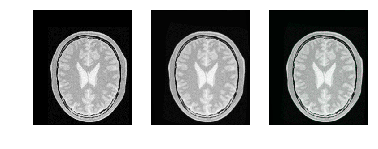

In [13]:
# fixed image
plt.subplot(1,3,1)
display_image(fixedImage)

# registered moving image (result)
plt.subplot(1,3,2)
display_image(resultImage)

# fixed image (red) and registered 
# moving image (green), with overlap in white
# note that the images completely overlap
# (i.e., no red or green)
plt.subplot(1,3,3)
overlay_fixed_moving(fixedImage, resultImage)

In this case, we are able to compensate for many non-rigid differences between the two images. Note, however, that brain image registration is a difficult to task because of complex anatomical variations. Entire registration packages are dedicated to brain image processing. You might want to consider a more refined approach in critical applications.

In the next section we introduce groupwise registration, where many images are registered simultaneously a mean frame of reference.